In [ ]:
"""
 @Time : 15/12/2020 19:01
 @Author : Alaa Grable
 """

!pip install emoji --upgrade # upgrade emoji to the latest version
import gc
#import os
import emoji as emoji
import re
import emoji
import string
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from transformers import AutoModel
from transformers import BertModel, BertTokenizer

class BERT_Arch(nn.Module):
    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.conv = nn.Conv2d(in_channels=13, out_channels=13, kernel_size=(3, 768), padding=(1,0))
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=(2, 1), stride=(1, 1))
        self.dropout = nn.Dropout(0.1)

        # Adjust `in_features` based on the output size before this layer
        self.fc = nn.Linear(455, 3)
        self.flat = nn.Flatten()
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):
        all_hidden_states = self.bert(sent_id, attention_mask=mask, output_hidden_states=True).hidden_states
        all_layers = all_hidden_states
        x = torch.transpose(torch.cat(tuple([t.unsqueeze(0) for t in all_layers]), 0), 0, 1)
        x = self.pool(self.dropout(self.relu(self.conv(self.dropout(x)))))

        # Flatten and feed into the fully connected layer
        x = self.fc(self.dropout(self.flat(self.dropout(x))))
        return self.softmax(x)



def read_dataset():
    data = pd.read_csv("labeled_data.csv")
    data = data.drop(['count', 'hate_speech', 'offensive_language', 'neither'], axis=1)
    #data = data.loc[0:9599,:]
    print(len(data))
    return data['tweet'].tolist(), data['class']


def pre_process_dataset(values):
    new_values = list()
    # Emoticons
    emoticons = [':-)', ':)', '(:', '(-:', ':))', '((:', ':-D', ':D', 'X-D', 'XD', 'xD', 'xD', '<3', '</3', ':\*',
                 ';-)',
                 ';)', ';-D', ';D', '(;', '(-;', ':-(', ':(', '(:', '(-:', ':,(', ':\'(', ':"(', ':((', ':D', '=D',
                 '=)',
                 '(=', '=(', ')=', '=-O', 'O-=', ':o', 'o:', 'O:', 'O:', ':-o', 'o-:', ':P', ':p', ':S', ':s', ':@',
                 ':>',
                 ':<', '^_^', '^.^', '>.>', 'T_T', 'T-T', '-.-', '*.*', '~.~', ':*', ':-*', 'xP', 'XP', 'XP', 'Xp',
                 ':-|',
                 ':->', ':-<',
                 '8-)', ':-P', ':-p', '=P', '=p', ':*)', '*-*', 'B-)', 'O.o', 'X-(', ')-X']
    for value in values:
        # Remove dots
        text = value.replace(".", "").lower() #Assign text here at the beginning of the loop
        text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text)
        users = re.findall("[@]\w+", text)
        for user in users:
            text = text.replace(user, "<user>")
        urls = re.findall(r'(https?://[^\s]+)', text)
        if len(urls) != 0:
            for url in urls:
                text = text.replace(url, "<url >")
        for emo in text:
            if emo in emoji.EMOJI_DATA: # Use emoji.EMOJI_DATA instead of UNICODE_EMOJI
                text = text.replace(emo, "<emoticon >")
        for emo in text:
            if emo in emoji.EMOJI_DATA:
                text = text.replace(emo, "<emoticon >")
        for emo in emoticons:
            text = text.replace(emo, "<emoticon >")
        numbers = re.findall('[0-9]+', text)
        for number in numbers:
            text = text.replace(number, "<number >")
        text = text.replace('#', "<hashtag >")
        text = re.sub(r"([?.!,¿])", r" ", text)
        text = "".join(l for l in text if l not in string.punctuation)
        text = re.sub(r'[" "]+', " ", text)
        new_values.append(text)
    return new_values


def data_process(data, labels):
    input_ids = []
    attention_masks = []
    bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    for sentence in data:
        bert_inp = bert_tokenizer.__call__(sentence, max_length=36,
                                           padding='max_length', pad_to_max_length=True,
                                           truncation=True, return_token_type_ids=False)

        input_ids.append(bert_inp['input_ids'])
        attention_masks.append(bert_inp['attention_mask'])
    #del bert_tokenizer
    #gc.collect()
    #torch.cuda.empty_cache()
    input_ids = np.asarray(input_ids)
    attention_masks = np.array(attention_masks)
    labels = np.array(labels)
    return input_ids, attention_masks, labels


def load_and_process():
    data, labels = read_dataset()
    num_of_labels = len(labels.unique())
    input_ids, attention_masks, labels = data_process(pre_process_dataset(data), labels)

    return input_ids, attention_masks, labels


# function to train the model
def train():
    model.train()

    total_loss, total_accuracy = 0, 0

    # empty list to save model predictions
    total_preds = []

    # iterate over batches
    total = len(train_dataloader)
    for i, batch in enumerate(train_dataloader):

        step = i+1
        percent = "{0:.2f}".format(100 * (step / float(total)))
        lossp = "{0:.2f}".format(total_loss/(total*batch_size))
        filledLength = int(100 * step // total)
        bar = '█' * filledLength + '>'  *(filledLength < 100) + '.' * (99 - filledLength)
        print(f'\rBatch {step}/{total} |{bar}| {percent}% complete, loss={lossp}, accuracy={total_accuracy}', end='')

        # push the batch to gpu
        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch
        del batch
        gc.collect()
        torch.cuda.empty_cache()
        # clear previously calculated gradients
        model.zero_grad()

        # get model predictions for the current batch
        #sent_id = torch.tensor(sent_id).to(device).long()
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss += float(loss.item())

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        #preds = preds.detach().cpu().numpy()

        # append the model predictions
        #total_preds.append(preds)
        total_preds.append(preds.detach().cpu().numpy())

    gc.collect()
    torch.cuda.empty_cache()

    # compute the training loss of the epoch
    avg_loss = total_loss / (len(train_dataloader)*batch_size)

    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds = np.concatenate(total_preds, axis=0)

    # returns the loss and predictions
    return avg_loss, total_preds


# function for evaluating the model
def evaluate():
    print("\n\nEvaluating...")

    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    total = len(val_dataloader)
    for i, batch in enumerate(val_dataloader):

        step = i+1
        percent = "{0:.2f}".format(100 * (step / float(total)))
        lossp = "{0:.2f}".format(total_loss/(total*batch_size))
        filledLength = int(100 * step // total)
        bar = '█' * filledLength + '>' * (filledLength < 100) + '.' * (99 - filledLength)
        print(f'\rBatch {step}/{total} |{bar}| {percent}% complete, loss={lossp}, accuracy={total_accuracy}', end='')

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch
        del batch
        gc.collect()
        torch.cuda.empty_cache()
        # deactivate autograd
        with torch.no_grad():

            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds, labels)

            total_loss += float(loss.item())
            #preds = preds.detach().cpu().numpy()

            #total_preds.append(preds)
            total_preds.append(preds.detach().cpu().numpy())

    gc.collect()
    torch.cuda.empty_cache()

    # compute the validation loss of the epoch
    avg_loss = total_loss / (len(val_dataloader)*batch_size)

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

# Specify the GPU
# Setting up the device for GPU usage
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Load Data-set ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
input_ids, attention_masks, labels = load_and_process()
df = pd.DataFrame(list(zip(input_ids, attention_masks)), columns=['input_ids', 'attention_masks'])
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ class distribution ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

# class = class label for majority of CF users. 0 - hate speech 1 - offensive language 2 - neither
# ~~~~~~~~~~ Split train data-set into train, validation and test sets  ~~~~~~~~~~#
train_text, temp_text, train_labels, temp_labels = train_test_split(df, labels,
                             random_state=2018, test_size=0.2, stratify=labels)

val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                         random_state=2018, test_size=0.5, stratify=temp_labels)

del temp_text
gc.collect()
torch.cuda.empty_cache()

train_count = len(train_labels)
test_count = len(test_labels)
val_count = len(val_labels)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

# ~~~~~~~~~~~~~~~~~~~~~ Import BERT Model and BERT Tokenizer ~~~~~~~~~~~~~~~~~~~~~#
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')
# bert = AutoModel.from_pretrained('bert-base-uncased')
# Load the BERT tokenizer
#tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Tokenization ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# for train set
train_seq = torch.tensor(train_text['input_ids'].tolist())
train_mask = torch.tensor(train_text['attention_masks'].tolist())
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(val_text['input_ids'].tolist())
val_mask = torch.tensor(val_text['attention_masks'].tolist())
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(test_text['input_ids'].tolist())
test_mask = torch.tensor(test_text['attention_masks'].tolist())
test_y = torch.tensor(test_labels.tolist())
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Create DataLoaders ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Freeze BERT Parameters ~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)
# push the model to GPU
model = model.to(device)

# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

#from sklearn.utils.class_weight import compute_class_weight

# compute the class weights
#class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)

#print(class_wts)

# convert class weights to tensor
#weights = torch.tensor(class_wts, dtype=torch.float)
#weights = weights.to(device)

# loss function
#cross_entropy = nn.NLLLoss(weight=weights)
cross_entropy = nn.NLLLoss()

# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
#train_losses = []
#valid_losses = []

#if os.path.isfile("/content/drive/MyDrive/saved_weights.pth") == False:
#if os.path.isfile("saved_weights.pth") == False:
    # number of training epochs
epochs = 3
current = 1
# for each epoch
while current <= epochs:

    print(f'\nEpoch {current} / {epochs}:')

    # train model
    train_loss, _ = train()

    # evaluate model
    valid_loss, _ = evaluate()

    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        #torch.save(model.state_dict(), 'saved_weights.pth')

    # append training and validation loss
    #train_losses.append(train_loss)
    #valid_losses.append(valid_loss)

    print(f'\n\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

    current = current + 1
#else:
    #print("Got weights!")
    # load weights of best model
    #model.load_state_dict(torch.load("saved_weights.pth"))
    #model.load_state_dict(torch.load("/content/drive/MyDrive/saved_weights.pth"), strict=False)

# get predictions for test data
gc.collect()
torch.cuda.empty_cache()

with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    #preds = model(test_seq, test_mask)
    preds = preds.detach().cpu().numpy()


print("Performance:")
# model's performance
preds = np.argmax(preds, axis=1)
print('Classification Report')
print(classification_report(test_y, preds))

print("Accuracy: " + str(accuracy_score(test_y, preds)))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 11.3 MB/s eta 0:00:00
cuda
24783


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

<ipython-input-1-e3581e5d9ba5>:289: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  train_seq = torch.tensor(train_text['input_ids'].tolist())
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Epoch 1 / 3:
Batch 620/620 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.01, accuracy=0

Evaluating...
Batch 78/78 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.01, accuracy=0

Training Loss: 0.011
Validation Loss: 0.008

Epoch 2 / 3:
Batch 620/620 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.01, accuracy=0

Evaluating...
Batch 78/78 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.01, accuracy=0

Training Loss: 0.007
Validation Loss: 0.008

Epoch 3 / 3:
Batch 620/620 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.01, accuracy=0

Evaluating...
Batch 78/78 |█████████████████████████████

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

# Assuming y_true and y_pred are your true labels and predicted labels
report = classification_report(test_y, preds, output_dict=True)
df_report = pd.DataFrame(report).transpose()


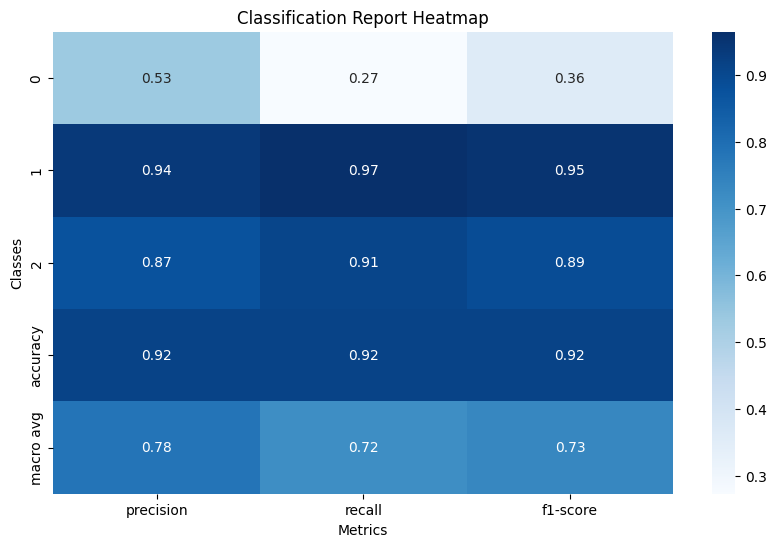

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only the main metrics and exclude support column
metrics = df_report.iloc[:-1, :-1]  # Exclude 'accuracy' row and 'support' column

plt.figure(figsize=(10, 6))
sns.heatmap(metrics, annot=True, cmap='Blues', fmt=".2f")
plt.title("Classification Report Heatmap")
plt.xlabel("Metrics")
plt.ylabel("Classes")
plt.show()



Epoch 1 / 3:
Batch 620/620 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.00, accuracy=0

Evaluating...
Batch 78/78 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.01, accuracy=0
Training Loss: 0.004, Training Accuracy: 0.641
Validation Loss: 0.009, Validation Accuracy: 0.904

Epoch 2 / 3:
Batch 620/620 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.00, accuracy=0

Evaluating...
Batch 78/78 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.01, accuracy=0
Training Loss: 0.003, Training Accuracy: 0.636
Validation Loss: 0.014, Validation Accuracy: 0.914

Epoch 3 / 3:
Batch 620/620 |█████████████████████████████████████████████████████████████████████████████████████████████

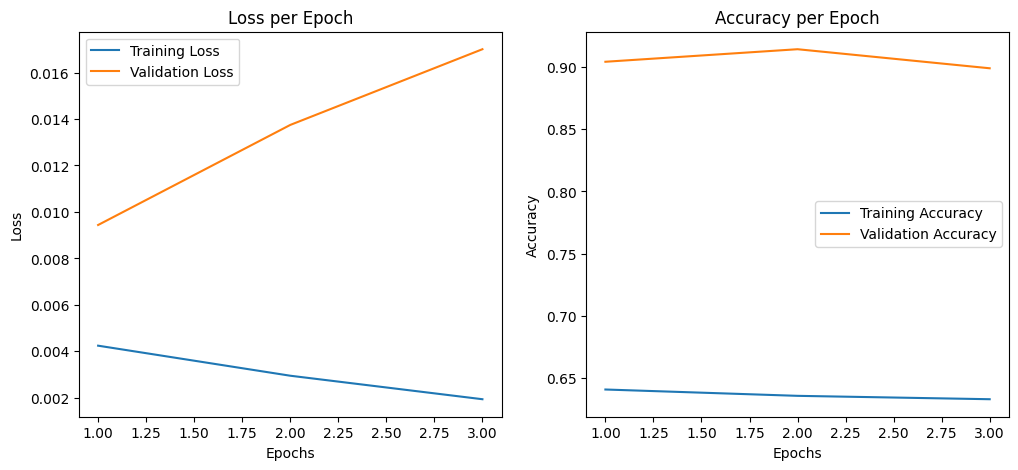


Final Performance on Test Set:
Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.49      0.47       143
           1       0.94      0.95      0.94      1919
           2       0.91      0.82      0.87       417

    accuracy                           0.90      2479
   macro avg       0.77      0.75      0.76      2479
weighted avg       0.90      0.90      0.90      2479

Test Accuracy: 0.9027833803953207


In [ ]:
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# Define lists to store accuracy and loss values for each epoch
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

# Initialize epochs and start training loop
epochs = 3
current = 1

# for each epoch
while current <= epochs:
    print(f'\nEpoch {current} / {epochs}:')

    # Train model and collect training loss and predictions
    train_loss, train_preds = train()

    # Evaluate model and collect validation loss and predictions
    valid_loss, valid_preds = evaluate()

    # Calculate accuracy for training and validation
    train_accuracy = accuracy_score(train_labels, np.argmax(train_preds, axis=1))
    valid_accuracy = accuracy_score(val_labels, np.argmax(valid_preds, axis=1))

    # Append the values to lists
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)

    print(f'\nTraining Loss: {train_loss:.3f}, Training Accuracy: {train_accuracy:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}, Validation Accuracy: {valid_accuracy:.3f}')

    current += 1

# Plotting Accuracy and Loss per Epoch
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, epochs + 1), valid_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, label="Training Accuracy")
plt.plot(range(1, epochs + 1), valid_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch")
plt.legend()

plt.show()

# Final Performance Evaluation on Test Set
gc.collect()
torch.cuda.empty_cache()

# Get predictions for the test data
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()

# Convert predictions to label indices
preds = np.argmax(preds, axis=1)

# Print Classification Report and Accuracy
print("\nFinal Performance on Test Set:")
print('Classification Report:')
print(classification_report(test_y, preds))
print("Test Accuracy:", accuracy_score(test_y, preds))


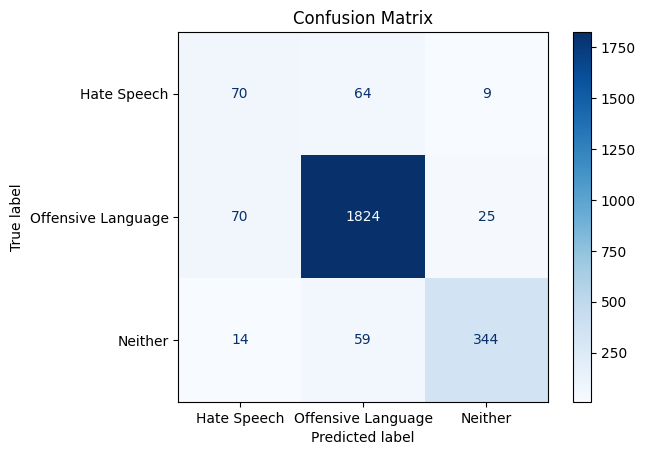

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute the confusion matrix
conf_matrix = confusion_matrix(test_y, preds)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Hate Speech", "Offensive Language", "Neither"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()
